In [1]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np

In [2]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
import pickle
import re
import joblib
import fitz

In [5]:
count_vec = joblib.load("vectorizer/vectorizer.pkl")
tfizer = joblib.load("vectorizer/tfidf_vectorizer.pkl")

In [85]:
count_vec.vocabulary_

{'moment': 574,
 'play': 667,
 'life': 513,
 'change': 128,
 'experience': 301,
 'today': 902,
 'perc': 646,
 'thing': 890,
 'friend': 360,
 'post': 679,
 'facebook': 312,
 'day': 209,
 'rest': 744,
 'hello': 416,
 'sorry': 814,
 'hear': 413,
 'natural': 587,
 'relationship': 733,
 'time': 898,
 'try': 919,
 'figure': 338,
 'hard': 406,
 'welcome': 967,
 'stuff': 853,
 'game': 371,
 'set': 774,
 'match': 551,
 'minute': 569,
 'move': 582,
 'don': 252,
 'mean': 556,
 'sit': 793,
 'maybe': 554,
 'healthy': 412,
 'basically': 75,
 'come': 152,
 've': 940,
 'determine': 232,
 'type': 922,
 'want': 954,
 'likely': 516,
 'use': 935,
 'give': 380,
 'cognitive': 148,
 'function': 367,
 'leave': 508,
 'video': 943,
 'good': 385,
 'note': 608,
 'somewhat': 811,
 'completely': 162,
 'death': 213,
 'dear': 212,
 'favorite': 326,
 'grow': 391,
 'current': 200,
 'cool': 183,
 'appear': 40,
 'late': 499,
 'sad': 753,
 'wait': 949,
 'think': 891,
 'confidence': 169,
 'inner': 458,
 'world': 983,
 'enj

In [6]:
b_pres_reverse = [
  {0: 'I', 1: 'E'},
  {0: 'N', 1: 'S'},
  {0: 'T', 1: 'F'},
  {0: 'J', 1: 'P'}
]

In [7]:
model = pickle.load(open("model/model.pkl", "rb"))

In [8]:
def translate_back(personality):
  s = ""
  for i, j in enumerate(personality):
    s += b_pres_reverse[i][j]
  return s

In [11]:
!python -m spacy download en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011737 sha256=65aa68f965a92c8503d01f48ffef5cf082ddf8990af03d1ae3675c1ea6db1650
  Stored in directory: /private/var/folders/fs/cxxsbdls25bd02mzl1rc7sw40000gn/T/pip-ephem-wheel-cache-g7nfbz3l/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en_core_web_sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/en_core_web_sm
-->
/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [9]:
nlp = spacy.load('en', disable = ['parse', 'ner'])

def  pre_process(data):
  list_posts = []

  for row in data.iterrows():
    posts = row[1].posts

    # remove url
    temp = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

    # remove non-words
    temp = re.sub(r'[^A-Za-z]', " ", temp)

    #remove more than one space
    temp = re.sub(' +', " ", temp).lower()

    #remove multiple letter repeating words
    temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

    #remove stop words
    doc = nlp(temp)
    temp = " ".join([tok.lemma_ for tok in doc if not tok.is_stop])

    list_posts.append(temp)

  list_posts = np.array(list_posts)
  return list_posts

In [10]:
test_resumes_dir = "test_resume"

In [11]:
import os

test_resumes_files = [os.path.join(test_resumes_dir, f) 
                      for f in os.listdir(test_resumes_dir) 
                      if f.endswith(".pdf")]

In [12]:
len(test_resumes_files)

390

In [13]:
my_posts = []
for fname in test_resumes_files:
    doc = fitz.open(fname)
    text = ""
    for page in doc:
      text += str(page.get_text())
    
    my_posts.append(text)

my_posts = [t.replace('\n', ' ').strip() for t in my_posts]
# my_data = pd.DataFrame(data={'type': 'INFJ', 'posts': my_posts})
my_data = pd.DataFrame(data={'posts': my_posts})


In [14]:
my_posts = pre_process(my_data)

In [16]:
my_posts

'inside account manager summary inside account manager year experience shi fill inside sale team manager position strong organizational analytical problem resolution skill vast account knowledge highlight team leadership customer service expert experience volume licensing staff training excellent time management organize meticulous computer savvy adept multi tasker experience company city state inside account manager current daily responsibility include quote customer relation order management experience train new hire develop necessary skill technique meet need client constant adaptation new opportunity challenge multiple account handle develop empathetic client relationship earn reputation exceed service expectation exclusively handle microsoft spla sandia national labs account multi year m novell contract company city state event manager sale associate responsible stock management customer relation provide knowledgeable assistance leader demonstration gaming product earn joy maker a

In [95]:
my_X_cnt = count_vec.transform(my_posts)

In [96]:
my_X_tfidf = tfizer.transform(my_X_cnt).toarray()

In [97]:
result = {}
probs = {}
for fname, x_tfidf in zip([i.split("/")[1] 
                              for i in test_resumes_files], 
                      my_X_tfidf):
    pred_result = []
    prob_result = []
    for i in model:
      y_pred = i.predict([x_tfidf])
      y_pred_prob = i.predict_proba([x_tfidf])
        
      pred_result.append(y_pred[0])
      prob_result.append(y_pred_prob[0] * 100)    
    
    result[fname] = pred_result
    probs[fname] = prob_result

In [70]:
for key in result:
    print(result[key])

[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 0, 1, 1]


In [98]:
actual_personality = {
    'I': "Introvert",
    'E': "Extrovert",
    'N': "Intution",
    'S': "Sensing",
    "T": "Thinking",
    'F': "Feeling",
    "J": "Judging",
    "P": "Perceiving"
}

In [99]:
pd_structure = {"name" :pd.Series([], dtype=pd.StringDtype())}
pd_structure.update({value: pd.Series([])  for value in actual_personality.values()})
pd_structure.update({"personality_cat": pd.Series([], dtype=pd.StringDtype())})
data_result = pd.DataFrame().from_dict(pd_structure)

/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  



In [100]:
data_result.dtypes

name                string
Introvert          float64
Extrovert          float64
Intution           float64
Sensing            float64
Thinking           float64
Feeling            float64
Judging            float64
Perceiving         float64
personality_cat     string
dtype: object

In [101]:
for key in result:
    temp = []
    personality_ = translate_back(result[key])
    probs_ = list(np.concatenate(probs[key]).flat)
    temp.append(key)
    temp += probs_
    temp.append(personality_)
    data_result.loc[len(data_result)] = temp

In [102]:
data_result

,name,Introvert,Extrovert,Intution,Sensing,Thinking,Feeling,Judging,Perceiving,personality_cat
0,25157655.pdf,74.871361,25.128641,82.359138,17.640860,41.360100,58.639900,43.326221,56.673779,INFP
1,70892619.pdf,81.371674,18.628321,88.945786,11.054212,32.484711,67.515289,62.347256,37.652744,INFJ
2,12334650.pdf,76.797958,23.202044,83.150864,16.849134,46.370853,53.629147,44.197578,55.802422,INFP
3,94230796.pdf,77.590218,22.409784,79.839798,20.160204,33.346855,66.653145,37.800129,62.199871,INFP
4,37201447.pdf,78.451279,21.548725,87.684624,12.315373,31.788313,68.211685,52.123199,47.876801,INFJ
...,...,...,...,...,...,...,...,...,...,...
385,39855211.pdf,72.180626,27.819370,83.226501,16.773495,33.070816,66.929184,57.784927,42.215073,INFJ
386,15139979.pdf,77.316368,22.683630,85.864990,14.135009,37.283909,62.716091,59.585018,40.414982,INFJ
387,56068028.pdf,74.335228,25.664768,86.478157,13.521846,49.039490,50.960510,57.835789,42.164211,INFJ
388,14206561.pdf,76.703438,23.296556,87.296989,12.703015,23.087543,76.912460,48.542480,51.457520,INFP


In [103]:
data_result["personality_cat"].value_counts()

INFP    221
INFJ    115
INTP     47
INTJ      7
Name: personality_cat, dtype: int64

In [79]:
import matplotlib.pyplot as plt

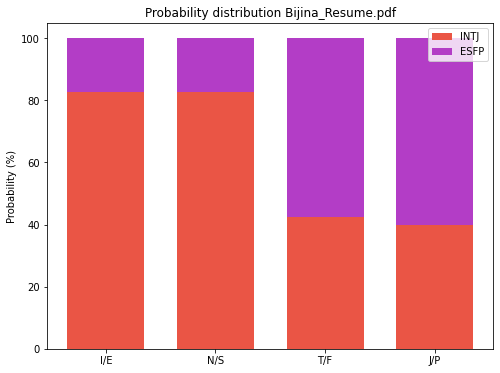

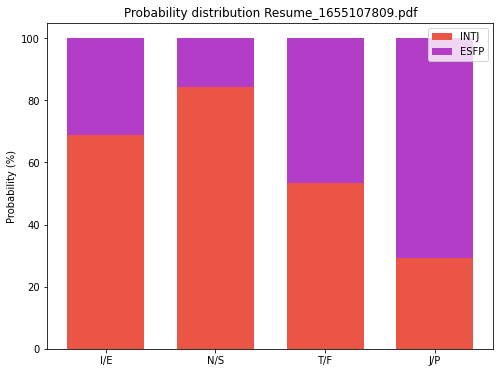

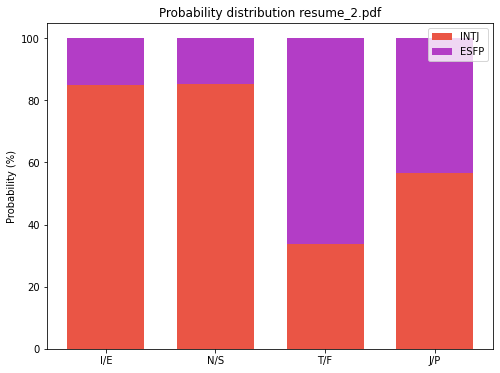

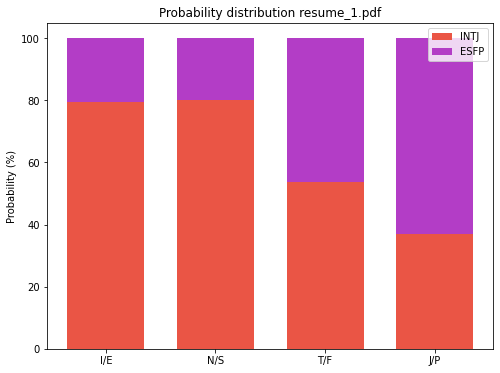

In [25]:
N = 4
ind = np.arange(N)
width = 0.7
for data in data_result.iterrows():
    data = data[1]
    bottom = (data["Introvert"], 
        data["Intution"], 
        data["Thinking"], data["Judging"])
    top = (data["Extrovert"], data["Sensing"],
          data["Felling"], data["Perceiving"])
    plt.figure(figsize=(8, 6))
    p1 = plt.bar(ind, bottom, width, 
                 label="INTJ", color="#ea5545")
    p2 = plt.bar(ind, top, width, bottom=bottom, label="ESFP", color="#b33dc6")


    plt.ylabel("Probability (%)")
    plt.title(f"Probability distribution {data['name']}")
    plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))
    plt.legend()
    plt.show()